In [1]:
# 数据接口 
import akshare as ak
import baostock as bs
import tushare as ts

# 基础模块
import datetime
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# 回测框架
import backtrader as bt

# 基础函数
import utilsJ

# 策略

### 现有指标：
+ 均线 
+ 布林带
+ MACD柱状图
+ RSI相对强弱
+ WilliamR指标

In [49]:
class Strategy_comp1(bt.Strategy):
    
    params = (
        # General params
        ('printlog', False),
        ('p_stake', 100),
        ('buy_signal', 'b'),
        ('sell_signal', 'b'),

        # Indicator params
        ('bollinger_per', 20),
        ('bollinger_dev', 2),
        ('rsi_short', 6),
        ('rsi_long', 12),
        ('wave_period', 7),
        ('wr', 14),
        
        # ATR params
        ('using_atr', False),
        ('atr_period', 14),
        ('atr_percent', 1),
    )
    
    
    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s: %s' % (dt.isoformat(), txt))
            #with open('log.txt', 'a') as file:
                #file.write('%s: %s \n' % (dt.isoformat(), txt))
        
    
    def __init__(self):
        # Keep references to lines in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low

        # Keep references to executed order & price
        self.buyprice = 0
        self.sellprice = 0
        self.order = None

        # Add indicators
        ## Wave indicator
        ### MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.wave_period)
        self.wave_buy = bt.And(self.sma(0) > self.sma(-1), self.sma(-1) < self.sma(-2), self.sma(-2) < self.sma(-3))
        self.wave_sell = bt.And(self.sma(0) < self.sma(-1), self.sma(-1) > self.sma(-2), self.sma(-2) > self.sma(-3))

        ## MACD indicator
        self.macdhisto = bt.indicators.MACDHisto(self.datas[0])
        self.macd_buy = bt.And(self.macdhisto.histo(0) > 0, self.macdhisto.histo(-1) < 0)
        self.macd_sell = bt.And(self.macdhisto.histo(0) < 0, self.macdhisto.histo(-1) > 0)
        
        ## Bollinger Bands indicator
        self.bolling = bt.indicators.BollingerBands(self.datas[0], 
                                                    period = self.params.bollinger_per, 
                                                    devfactor = self.params.bollinger_dev)
        self.bolling_buy = bt.Or(bt.And(self.dataclose(0) > self.bolling.top(0), self.dataclose(-1) < self.bolling.top(-1)), 
                                 bt.And(self.dataclose(0) > self.bolling.bot(0), self.dataclose(-1) < self.bolling.bot(-1)))
        self.bolling_sell = bt.Or(bt.And(self.dataclose(0) < self.bolling.top(0), self.dataclose(-1) > self.bolling.top(-1)), 
                                  bt.And(self.dataclose(0) < self.bolling.bot(0), self.dataclose(-1) > self.bolling.bot(-1)))

        ## RSI indicator
        self.rsi_s = bt.indicators.RelativeStrengthIndex(period=self.params.rsi_short, safediv=True)
        self.rsi_l = bt.indicators.RelativeStrengthIndex(period=self.params.rsi_long, safediv=True)
        self.rsi_buy = bt.And(self.rsi_s(0) > self.rsi_l(0), self.rsi_s(-1) < self.rsi_l(-1))
        self.rsi_sell = bt.And(self.rsi_s(0) < self.rsi_l(0), self.rsi_s(-1) > self.rsi_l(-1))

        ## WilliamR indicator
        self.wr = bt.indicators.WilliamsR(period=self.params.wr)
        self.wr_buy = self.wr < -80
        self.wr_sell = self.wr > -20

        ## ATR indicator
        self.atr_initial = self.broker.get_cash()
        self.tr = bt.indicators.Max((self.datahigh - self.datalow), 
                                    abs(self.dataclose(-1) - self.datahigh),
                                    abs(self.dataclose(-1) - self.datalow))
        self.atr = bt.indicators.SimpleMovingAverage(self.tr, period=self.params.atr_period)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                if self.wave_buy:
                    self.buyprice = order.executed.price
                self.log('BUY EXECUTED, Price:%.2f, Lot:%i, Cash:%i.' %
                         (order.executed.price,
                          order.executed.size,
                          self.broker.get_cash()))

            else:  # Sell
                self.sellprice = order.executed.price
                self.log('SELL EXECUTED, Price:%.2f, Lot:%i, Cash:%i.' %
                        (order.executed.price,
                          -order.executed.size,
                          self.broker.get_cash()))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        #self.order = None


    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        buy_indicator = (self.params.buy_signal == 'b' and self.bolling_buy) or \
                        (self.params.buy_signal == 'm' and self.macd_buy) or \
                        (self.params.buy_signal == 'w' and self.wave_buy and self.dataclose[0] > self.buyprice) or \
                        (self.params.buy_signal == 'r' and self.rsi_buy) or \
                        (self.params.buy_signal == 'wr' and self.wr_buy)
                        
        sell_indicator = (self.params.sell_signal == 'b' and self.bolling_sell) or \
                         (self.params.sell_signal == 'm' and self.macd_sell) or \
                         (self.params.sell_signal == 'w' and self.wave_sell) or \
                         (self.params.sell_signal == 'r' and self.rsi_sell) or \
                         (self.params.sell_signal == 'wr' and self.wr_sell)
            
        if buy_indicator:
            if self.params.using_atr:
                opt_pos = np.round(self.atr_initial * self.params.atr_percent / self.params.p_stake / self.atr[0])
                if opt_pos*self.params.p_stake > 0 and self.getposition(self.data).size < opt_pos*self.params.p_stake:
                    self.log('BUY CREATE, Price: %.2f, Lots: %i, Current Position: %i' % 
                             (self.dataclose[0], 
                             opt_pos*self.params.p_stake-self.getposition(self.data).size,
                             self.getposition(self.data).size))
                    self.buy(size=opt_pos*self.params.p_stake-self.getposition(self.data).size)
                
                elif opt_pos*self.params.p_stake > 0 and self.getposition(self.data).size > opt_pos*self.params.p_stake:
                    self.log('SELL CREATE, Price: %.2f, Lots: %i, Current Position: %i' % 
                            (self.dataclose[0], 
                            self.getposition(self.data).size-opt_pos*self.params.p_stake,
                            self.getposition(self.data).size))
                    self.sell(size=self.getposition(self.data).size-opt_pos*self.params.p_stake)
            else:
                self.log('BUY CREATE, Price: %.2f, Lots: %i, Current Position: %i' % (self.dataclose[0], 
                        self.params.p_stake,
                        self.getposition(self.data).size))
                self.buy(size=self.params.p_stake)
        elif sell_indicator and self.getposition(self.data).size > 0:
            self.log('Sell CREATE(Close), Price: %.2f, Current Position: %i' % (self.dataclose[0],
                        self.getposition(self.data).size))
            self.close()


    def stop(self):
        self.log('Ending Position:%i. Ending Value:%.2f.' %
                (self.getposition(self.data).size,
                self.cerebro.broker.getvalue()), doprint=False)

# 循环回测

In [50]:
if __name__ ==  '__main__':
    buy_s = ['b','m','w', 'r', 'wr']
    sell_s = ['b','m','w', 'r', 'wr']
    profit_dict = {}
    for s in product(*[buy_s, sell_s]):

        # Create a cerebro entity
        cerebro = bt.Cerebro()

        # Add a strategy
        strats = cerebro.addstrategy(Strategy_comp1, printlog=False, using_atr=True, atr_percent=0.01, buy_signal = s[0], sell_signal = s[1]) 

        s_date = datetime.date(2020,12,31) - datetime.timedelta(days=365)
        e_date = datetime.date(2020,12,31)

        # Create stock Data Feed
        stock_index = '600918.SH'
        #df = utilsJ.stock_tushare('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6', 
        #                    stock_index, s_date, e_date)
        df = pd.read_csv('.\\Data\\' + stock_index + '.csv')
        df.index=pd.to_datetime(df.trade_date)
        data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

        # Add the index Data Feed to Cerebo
        cerebro.adddata(data)
        
        # Set cash inside the strategy
        cerebro.broker = bt.brokers.BackBroker(coc=True)   
        cerebro.broker.setcash(50000)

        # Set commission
        #cerebro.broker.setcommission()

        # Print out the starting conditions
        start_value = cerebro.broker.getvalue()
        #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

        # Run over everything
        cerebro.run()

        # Print out the final result
        final_value = cerebro.broker.getvalue()
        #print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
        #print('Net Profit: %.2f%%' % ((final_value - start_value) / start_value * 100))
        profit_dict[s] = (final_value - start_value) / start_value * 100
    
    print(sorted(profit_dict.items(), key=lambda x: x[1], reverse=True)[:5])

[(('w', 'wr'), 5.038), (('wr', 'wr'), 5.0040000000000004), (('w', 'r'), 4.682), (('b', 'wr'), 4.486), (('wr', 'r'), 4.428)]


# 报告

In [48]:
if __name__ ==  '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    strats = cerebro.addstrategy(Strategy_comp1, printlog=True, using_atr=True, atr_percent=0.01, buy_signal = 'wr', sell_signal = 'm') 

    s_date = datetime.date(2020,12,31) - datetime.timedelta(days=365)
    e_date = datetime.date(2020,12,31)

    # Create stock Data Feed
    stock_index = '600918.SH'
    #df = utilsJ.stock_tushare('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6', 
    #                    stock_index, s_date, e_date)
    df = pd.read_csv('.\\Data\\' + stock_index + '.csv')
    df.index=pd.to_datetime(df.trade_date)
    data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

    # Add the index Data Feed to Cerebo
    cerebro.adddata(data)
    
    # Set cash inside the strategy
    cerebro.broker = bt.brokers.BackBroker(coc=True)   
    cerebro.broker.setcash(50000)

    # Set commission
    #cerebro.broker.setcommission()

    # Print out the starting conditions
    start_value = cerebro.broker.getvalue()
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    final_value = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('Net Profit: %.2f%%' % ((final_value - start_value) / start_value * 100))

Starting Portfolio Value: 50000.00


ZeroDivisionError: float division by zero

<IPython.core.display.Javascript object>


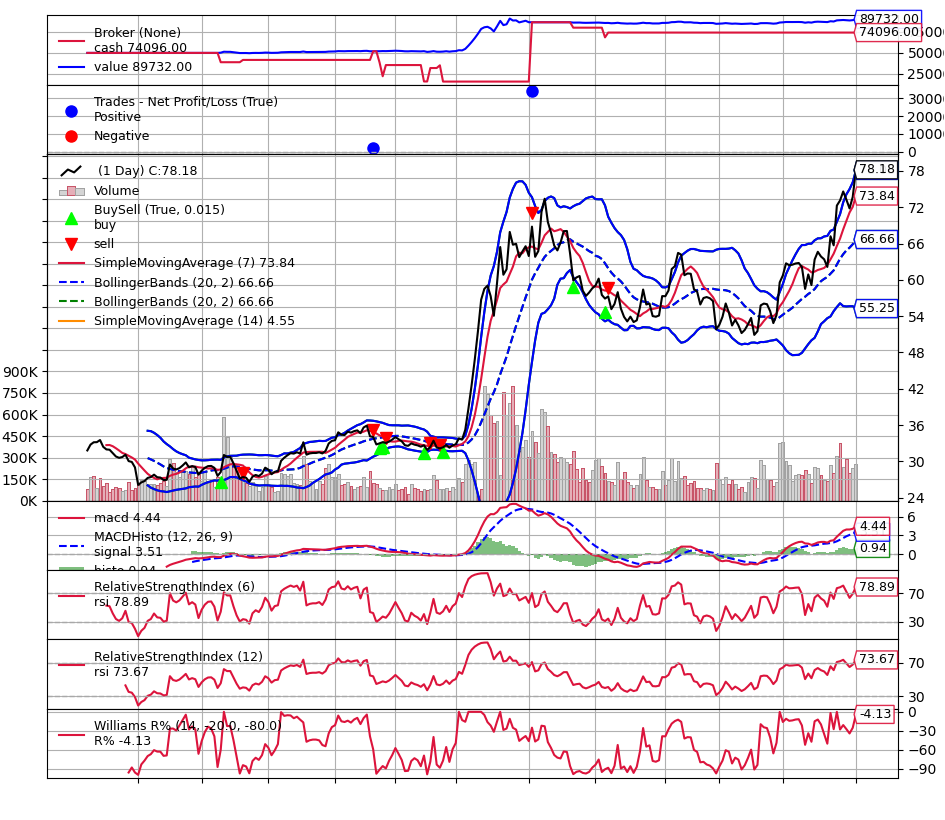

[[<Figure size 640x480 with 8 Axes>]]

In [23]:
cerebro.plot()